Found 9 A2D2 datasets

PROCESSING A2D2 DATASETS WITH LOCATION AND ROAD TYPE DETECTION

📂 Processing Dataset_1 - Gaimersheim
   File: 20180810150607_bus_signals.json
----------------------------------------------------------------------------------------------------
  ✅ JSON loaded successfully (22 sensors found)
  🚗 ROAD TYPE: Mixed (confidence: 50.0%)
     Reason: Mixed characteristics: speed=28.6, CV=0.61

  ⏱  Total recording duration: 525.75 seconds (8.76 minutes)
  🔹 accelerator_pedal: 52576 samples | Rate: 100.0 Hz | Mean: 11.80 %
  🔹 vehicle_speed: 26288 samples | Rate: 50.0 Hz | Mean: 28.59 km/h

📂 Processing Dataset_2 - Munich
   File: 20190401121727_bus_signals.json
----------------------------------------------------------------------------------------------------
  ✅ JSON loaded successfully (22 sensors found)
  🚗 ROAD TYPE: Urban/City (confidence: 95.0%)
     Reason: Low mean speed (12.7 km/h), high stops (63.2%)

  ⏱  Total recording duration: 919.68 seconds (15.33 minute

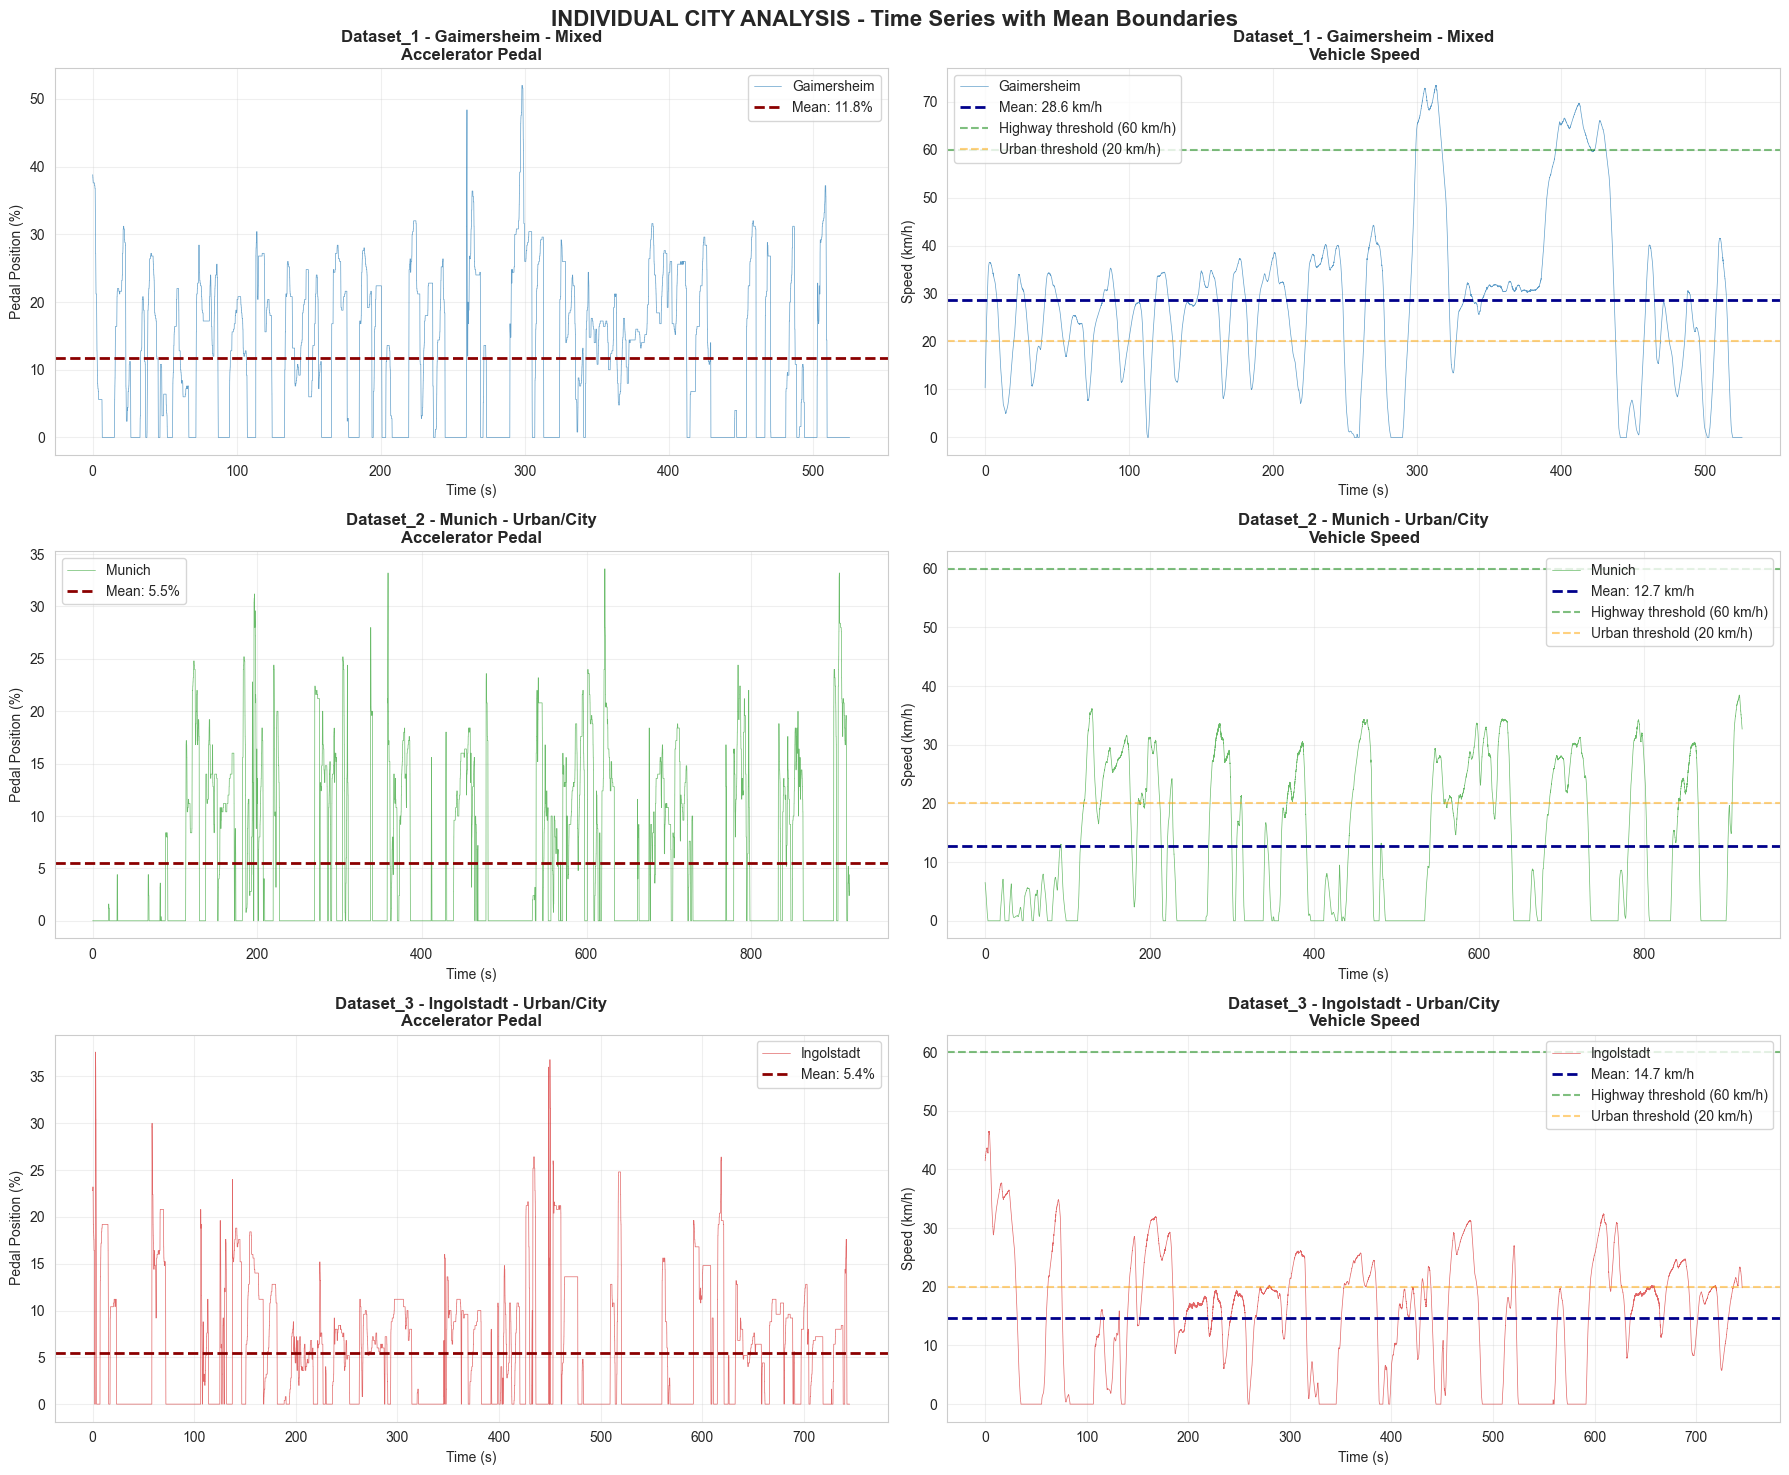

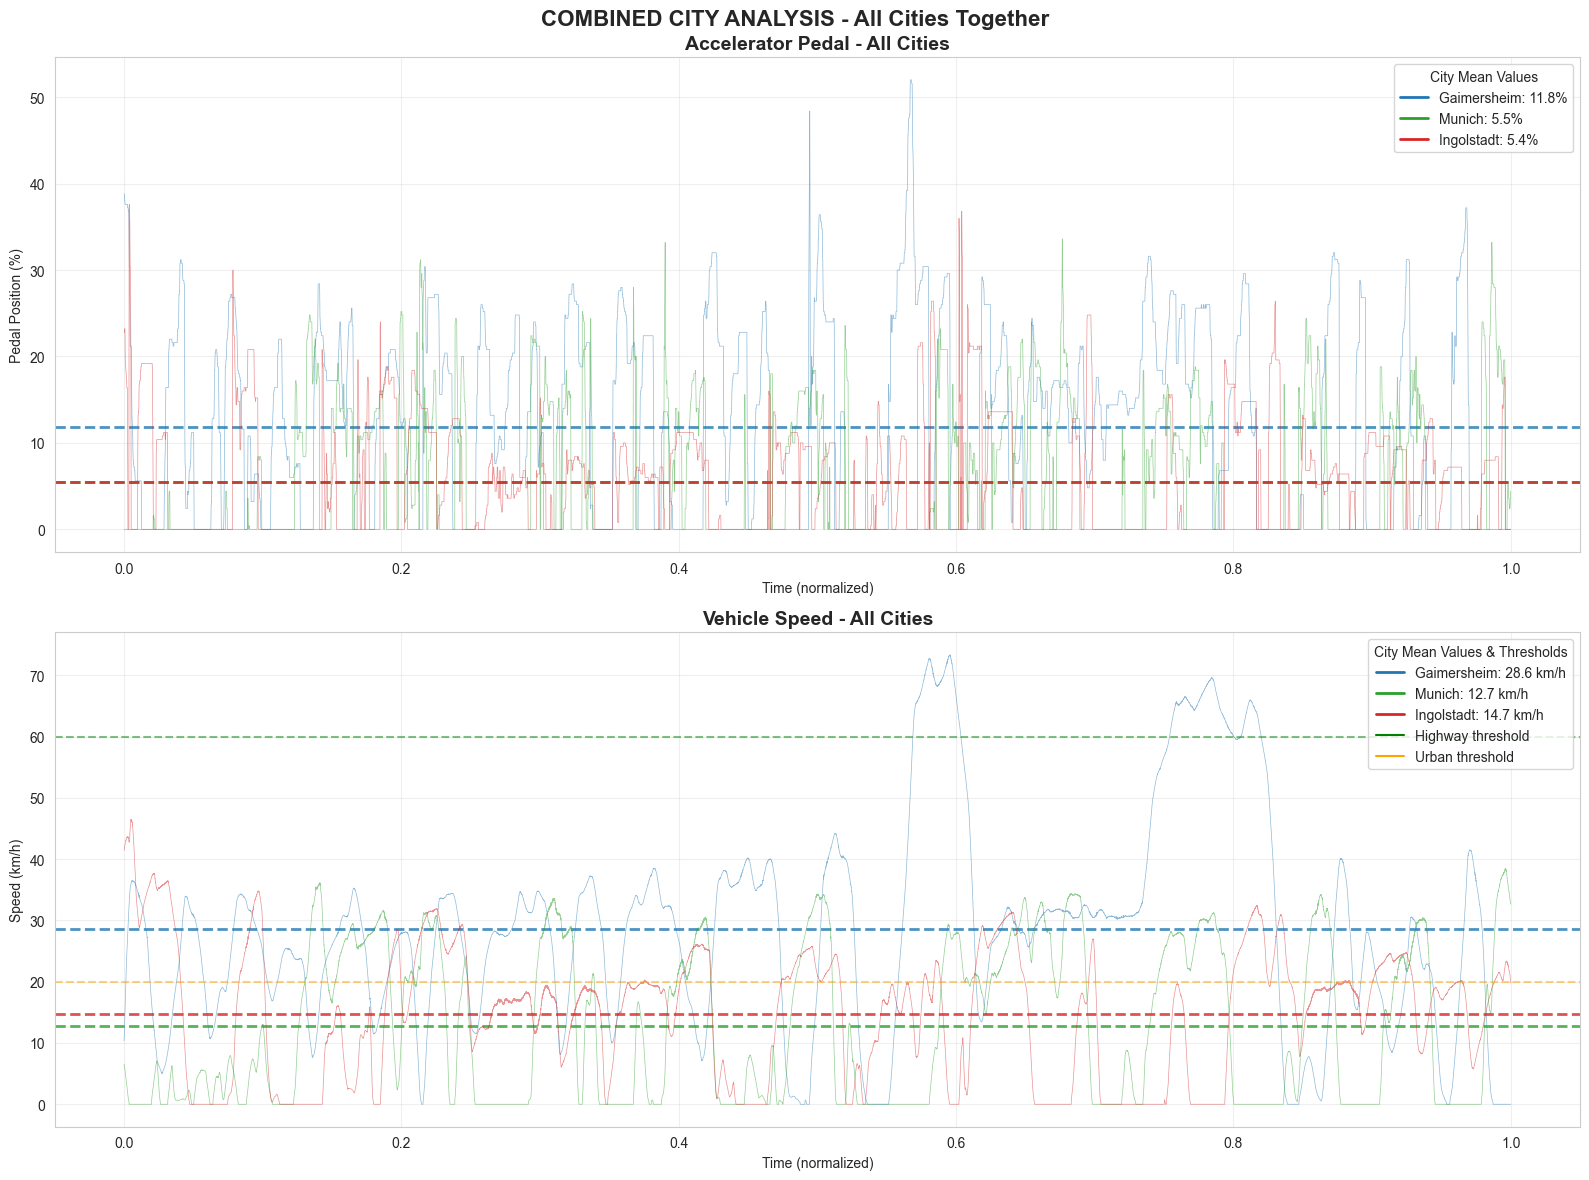

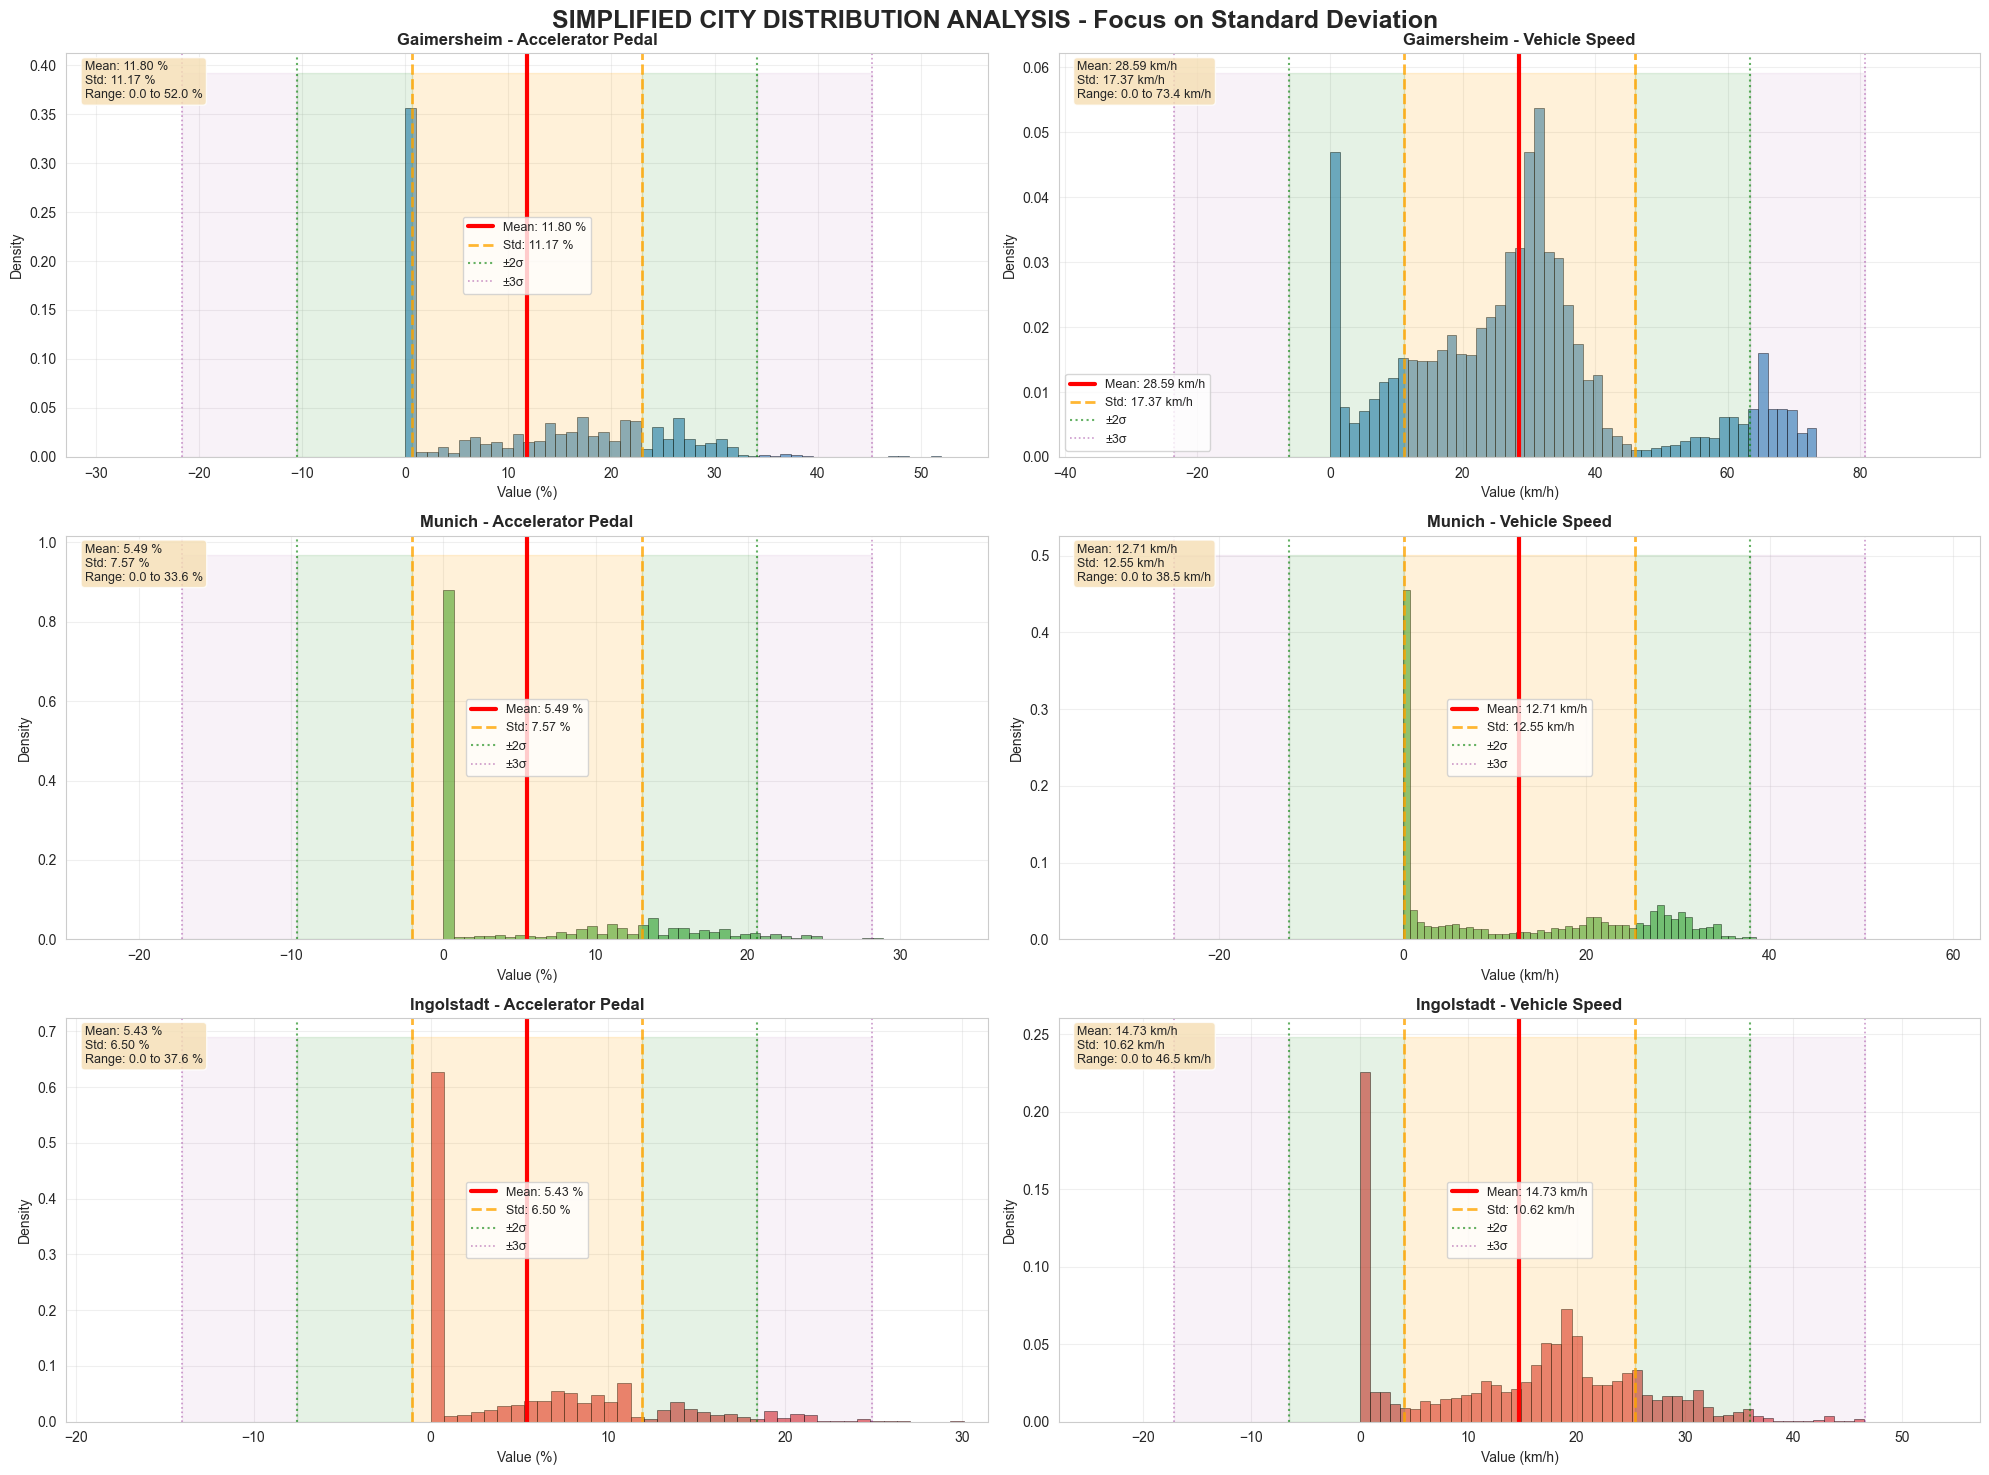

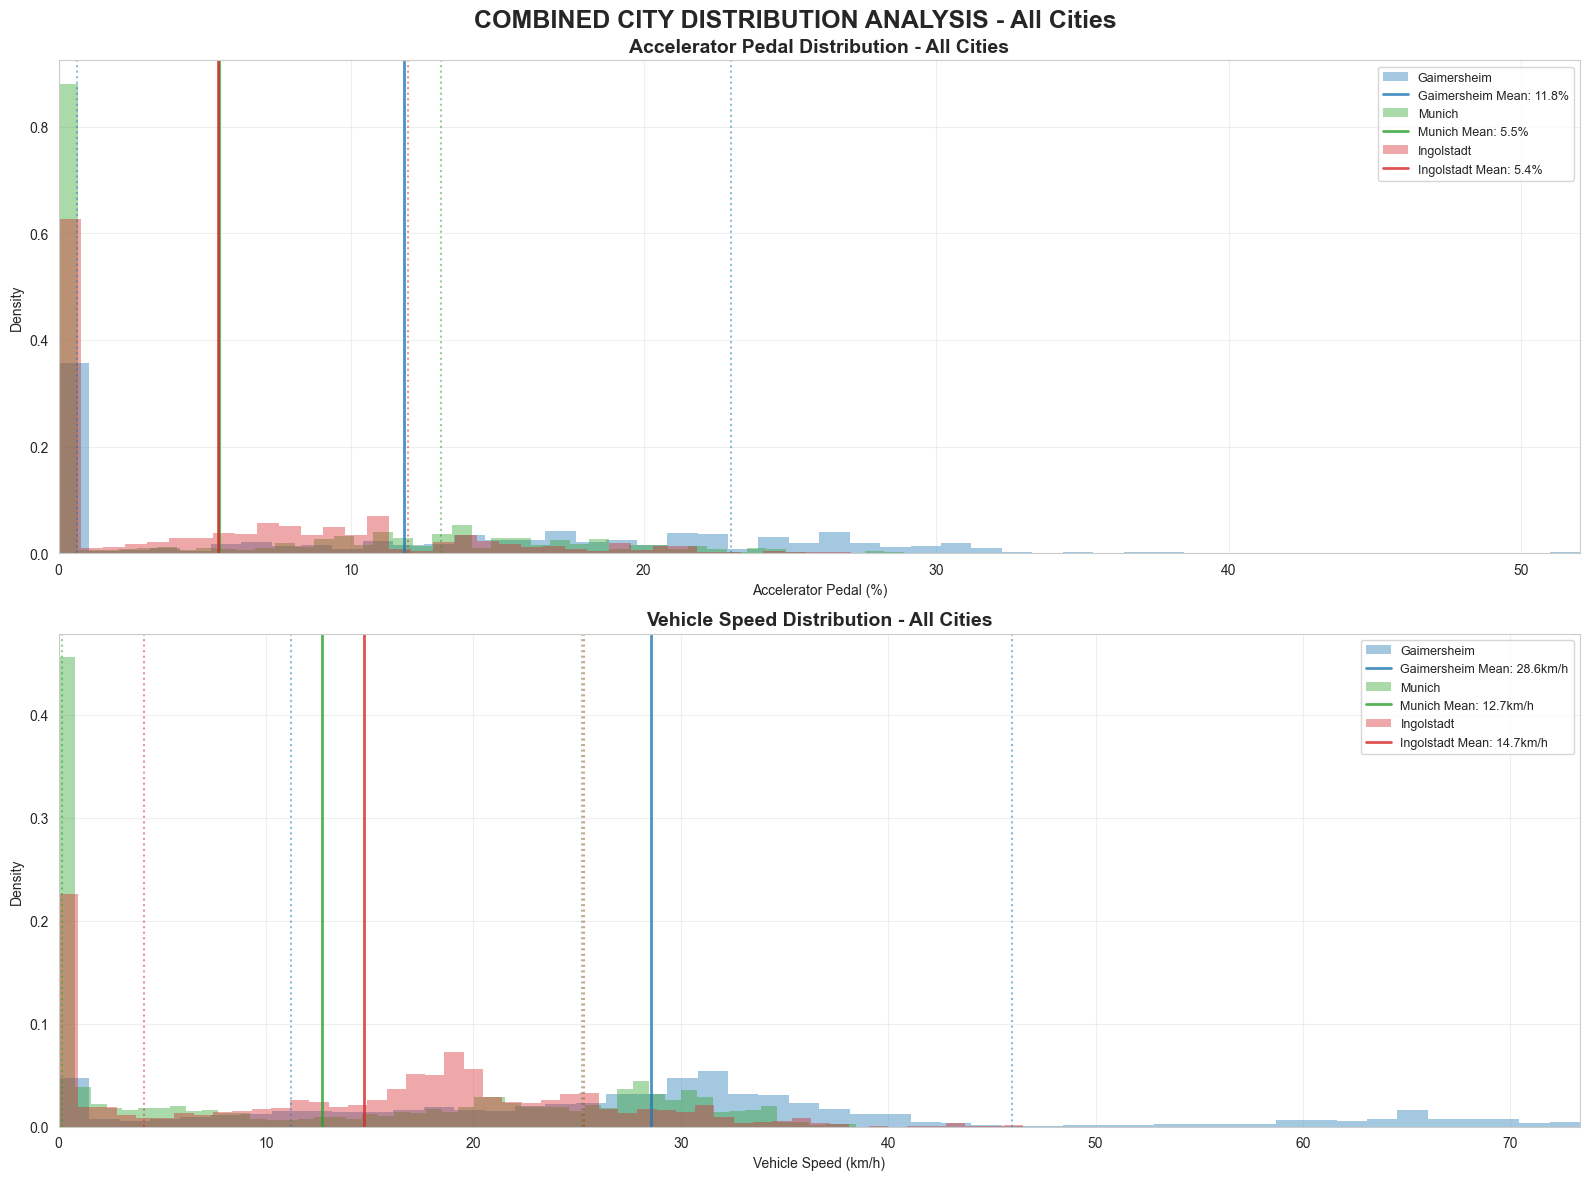

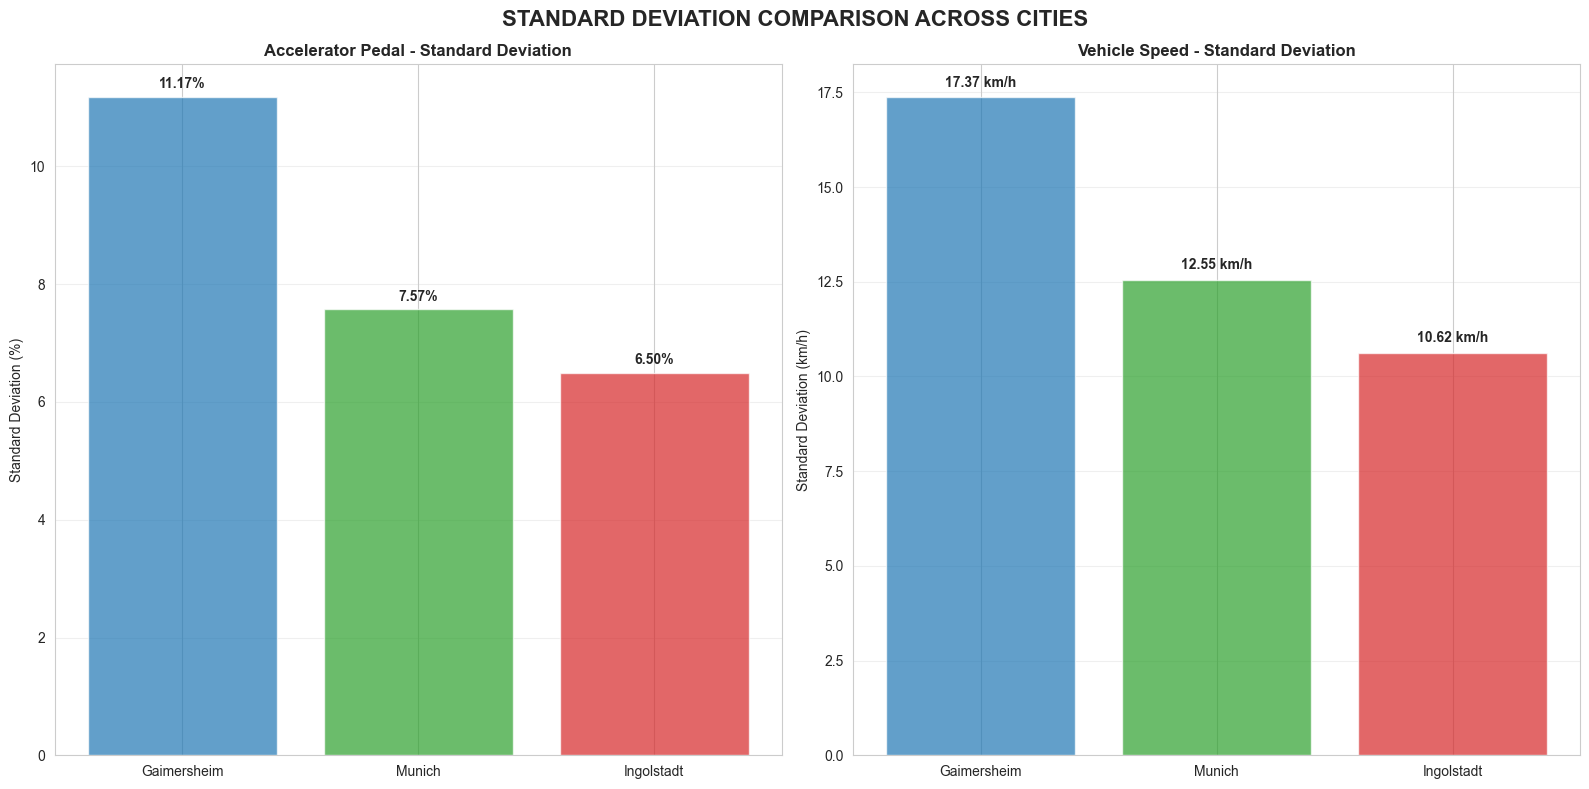

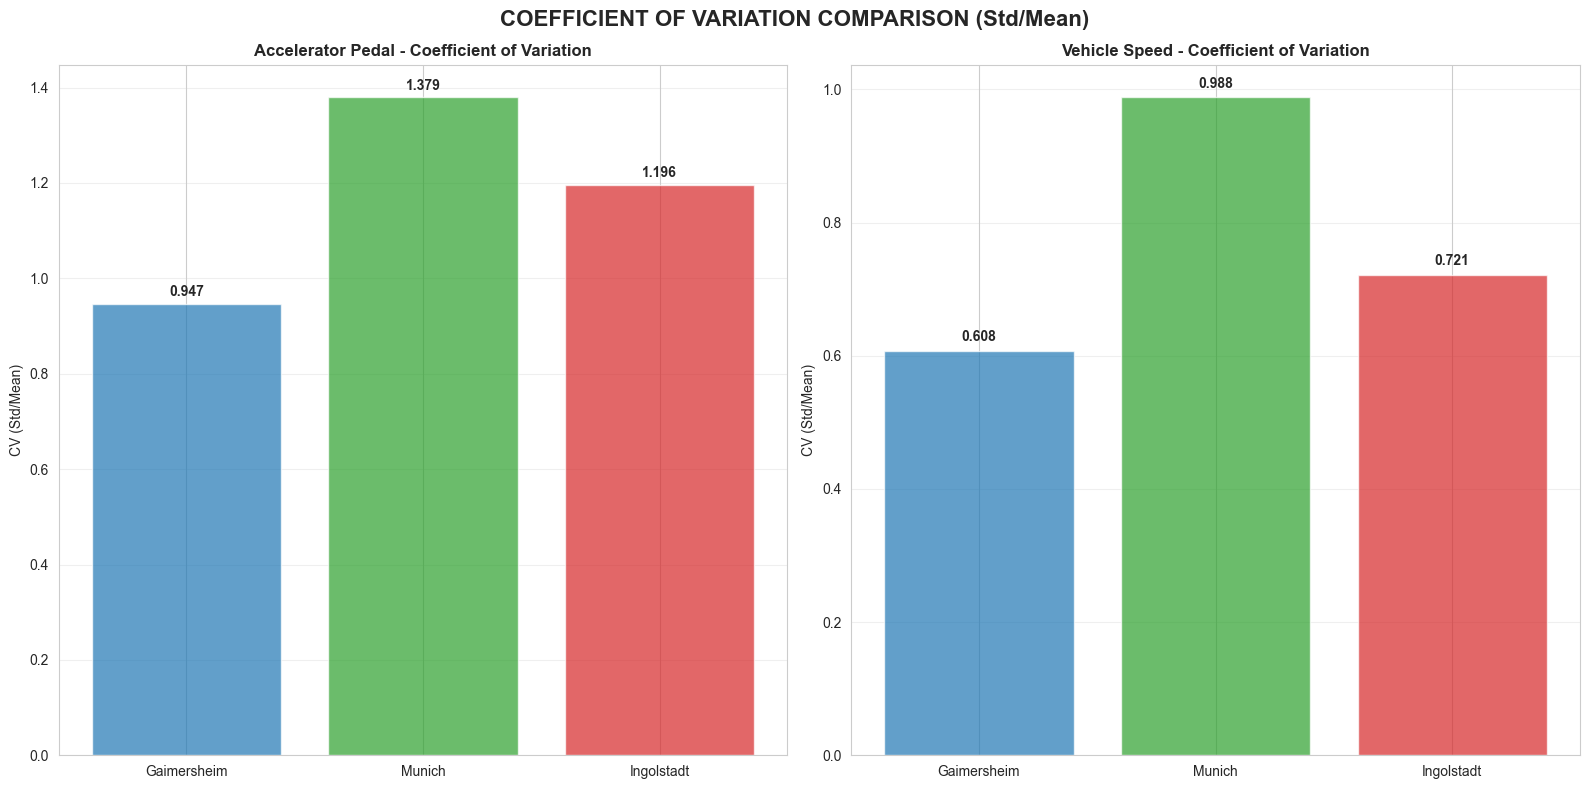

✅ Saved: a2d2_analysis_with_location.csv
✅ Saved: a2d2_driving_profiles.csv
✅ Saved: a2d2_statistical_summary.csv

DONE - All datasets processed with city and road type classification
📊 Summary of created visualizations:
   1. individual_city_analysis.png - Individual city time series with mean boundaries
   2. combined_city_analysis.png - All cities together in time series
   3. simplified_city_distributions.png - Simplified distribution plots focusing on std deviation
   4. combined_simplified_distributions.png - Combined simplified distribution plots
   5. std_deviation_comparison.png - Bar charts comparing standard deviations
   6. coefficient_variation_comparison.png - Bar charts comparing CV (std/mean)
📈 Key features of simplified distribution plots:
   - Clean histogram only (no KDE or normal curves)
   - Mean line (red)
   - Standard deviation lines (±1σ, ±2σ, ±3σ)
   - Shaded regions showing different standard deviation ranges
   - X-axis shows actual values (km/h or %)
   - S

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
from scipy import stats

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")
sns.set_palette("husl")

# =====================
# CONFIGURATION
# =====================
DATA_DIR = r'D:\LapTop\Downloads\abbosh\Project\A2D2'

# Find all JSON files
json_files = glob.glob(os.path.join(DATA_DIR, '**', '*bus_signals.json'), recursive=True)
print(f"Found {len(json_files)} A2D2 datasets")
print()

# Known cities from A2D2 paper (Section 3.3)
KNOWN_CITIES = ['Gaimersheim', 'Munich', 'Ingolstadt']

# Map first 3 files to cities (you may need to verify this manually)
dataset_mapping = {}
for i in range(min(3, len(json_files))):
    filename = os.path.basename(json_files[i])
    city = KNOWN_CITIES[i] if i < len(KNOWN_CITIES) else f"Unknown_City_{i+1}"
    dataset_mapping[filename] = {
        'id': f"Dataset_{i+1}",
        'city': city,
        'road_type': 'TBD'  # Will be determined by statistics
    }

target_sensors = ['accelerator_pedal', 'vehicle_speed']
units = {
    'accelerator_pedal': '%',
    'vehicle_speed': 'km/h'
}

dataset_data = []
all_results = []
driving_profiles = []

# =====================
# DRIVING PROFILE CLASSIFICATION FUNCTION
# =====================
def classify_driving_profile(speed_data):
    """
    Classify road type based on speed statistics.
    
    Returns: dict with classification and confidence
    """
    # Remove NaN/invalid values
    speed = speed_data[~np.isnan(speed_data)]
    
    if len(speed) == 0:
        return {'type': 'Unknown', 'confidence': 0.0, 'reason': 'No valid data'}
    
    # Compute key statistics
    mean_speed = np.mean(speed)
    std_speed = np.std(speed)
    cv = std_speed / (mean_speed + 1e-6)  # Coefficient of variation
    
    # Percentage of time at low speed (<20 km/h)
    pct_low_speed = np.sum(speed < 20) / len(speed) * 100
    
    # Percentage of time at high speed (>60 km/h)
    pct_high_speed = np.sum(speed > 60) / len(speed) * 100
    
    # Speed variance
    variance = np.var(speed)
    
    # Acceleration variance (rate of change)
    if len(speed) > 1:
        accel = np.diff(speed)
        accel_variance = np.var(accel)
    else:
        accel_variance = 0
    
    # Classification logic
    if mean_speed > 60 and pct_high_speed > 50 and cv < 0.4:
        road_type = 'Highway'
        confidence = min(0.95, 0.6 + pct_high_speed/100)
        reason = f"High mean speed ({mean_speed:.1f} km/h), low variability (CV={cv:.2f})"
    
    elif mean_speed < 40 and pct_low_speed > 30 and cv > 0.6:
        road_type = 'Urban/City'
        confidence = min(0.95, 0.5 + pct_low_speed/100)
        reason = f"Low mean speed ({mean_speed:.1f} km/h), high stops ({pct_low_speed:.1f}%)"
    
    elif 30 <= mean_speed <= 60 and 0.4 <= cv <= 0.8:
        road_type = 'Country Road'
        confidence = 0.70
        reason = f"Moderate speed ({mean_speed:.1f} km/h), moderate variability (CV={cv:.2f})"
    
    else:
        road_type = 'Mixed'
        confidence = 0.50
        reason = f"Mixed characteristics: speed={mean_speed:.1f}, CV={cv:.2f}"
    
    return {
        'type': road_type,
        'confidence': confidence,
        'reason': reason,
        'stats': {
            'mean_speed': mean_speed,
            'std_speed': std_speed,
            'cv': cv,
            'pct_low_speed': pct_low_speed,
            'pct_high_speed': pct_high_speed,
            'variance': variance,
            'accel_variance': accel_variance
        }
    }

# =====================
# DATA PROCESSING PIPELINE
# =====================
print("="*100)
print("PROCESSING A2D2 DATASETS WITH LOCATION AND ROAD TYPE DETECTION")
print("="*100)
print()

city_data = {}  # Store data by city for combined analysis

for dataset_file, info in dataset_mapping.items():
    dataset_path = None
    
    # Find full path
    for jp in json_files:
        if os.path.basename(jp) == dataset_file:
            dataset_path = jp
            break
    
    if dataset_path is None:
        print(f"❌ File not found: {dataset_file}")
        continue
    
    print(f"📂 Processing {info['id']} - {info['city']}")
    print(f"   File: {dataset_file}")
    print("-"*100)
    
    # 1. Load JSON data
    try:
        with open(dataset_path, 'r') as f:
            data = json.load(f)
        print(f"  ✅ JSON loaded successfully ({len(data)} sensors found)")
    except Exception as e:
        print(f"  ❌ Error loading {dataset_file}: {str(e)}")
        continue

    # 2. Flatten into DataFrame
    rows = []
    for sensor, sensor_info in data.items():
        if sensor not in target_sensors:
            continue
        
        if not isinstance(sensor_info, dict) or 'values' not in sensor_info:
            continue
        
        for ts, val in sensor_info['values']:
            rows.append({
                'sensor': sensor,
                'timestamp_us': ts,
                'value': val,
                'dataset': info['id'],
                'city': info['city']
            })
    
    if not rows:
        print(f"  ❌ No target sensor data found in {dataset_file}")
        continue
    
    df = pd.DataFrame(rows)
    
    # 3. Convert timestamp to datetime
    df['datetime'] = pd.to_datetime(df['timestamp_us'], unit='us')
    
    # 4. CLASSIFY DRIVING PROFILE based on speed
    speed_data = df[df['sensor'] == 'vehicle_speed']['value'].values
    profile = classify_driving_profile(speed_data)
    
    # Update road type in mapping
    dataset_mapping[dataset_file]['road_type'] = profile['type']
    
    print(f"  🚗 ROAD TYPE: {profile['type']} (confidence: {profile['confidence']*100:.1f}%)")
    print(f"     Reason: {profile['reason']}")
    print()
    
    # Store profile
    driving_profiles.append({
        'Dataset': info['id'],
        'City': info['city'],
        'Road Type': profile['type'],
        'Confidence': f"{profile['confidence']*100:.1f}%",
        'Mean Speed (km/h)': f"{profile['stats']['mean_speed']:.2f}",
        'Speed CV': f"{profile['stats']['cv']:.3f}",
        '% Low Speed (<20)': f"{profile['stats']['pct_low_speed']:.1f}%",
        '% High Speed (>60)': f"{profile['stats']['pct_high_speed']:.1f}%"
    })
    
    # 5. Store for visualization
    dataset_data.append({
        'location': info['city'],
        'dataset_id': info['id'],
        'filename': dataset_file,
        'road_type': profile['type'],
        'data': df
    })
    
    # Store data by city for combined analysis
    if info['city'] not in city_data:
        city_data[info['city']] = []
    city_data[info['city']].append(df)
    
    # 6. Calculate dataset statistics
    start_time = df['datetime'].min()
    end_time = df['datetime'].max()
    total_duration = (end_time - start_time).total_seconds()
    print(f"  ⏱  Total recording duration: {total_duration:.2f} seconds ({total_duration/60:.2f} minutes)")
    
    # 7. Per-sensor analysis with timestamps
    for sensor in target_sensors:
        sub = df[df['sensor'] == sensor]
        if sub.empty:
            print(f"  ⚠️  Missing {sensor} data")
            continue
        
        # Time calculations
        t_min = sub['datetime'].min()
        t_max = sub['datetime'].max()
        duration = (t_max - t_min).total_seconds()
        
        # Sampling rate calculation
        timestamps = sub['timestamp_us'].values
        if len(timestamps) > 1:
            dt = np.diff(timestamps)
            avg_dt_us = np.mean(dt)
            sampling_rate_hz = 1e6 / avg_dt_us
        else:
            sampling_rate_hz = 0
        
        # Statistical analysis
        mean_val = sub['value'].mean()
        std_val = sub['value'].std()
        min_val = sub['value'].min()
        max_val = sub['value'].max()
        dynamic_range = max_val - min_val
        unit = units[sensor]
        
        # Store results
        all_results.append({
            'Dataset ID': info['id'],
            'City': info['city'],
            'Road Type': profile['type'],
            'Sensor': sensor,
            'Start Time': t_min.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3],
            'End Time': t_max.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3],
            'Count': len(sub),
            'Duration (s)': f"{duration:.2f}",
            'Sampling Rate (Hz)': f"{sampling_rate_hz:.1f}",
            'Mean': f"{mean_val:.4f}",
            'Std Dev': f"{std_val:.4f}",
            'Min': f"{min_val:.4f}",
            'Max': f"{max_val:.4f}",
            'Dynamic Range': f"{dynamic_range:.4f}",
            'Unit': unit
        })
        
        print(f"  🔹 {sensor}: {len(sub)} samples | Rate: {sampling_rate_hz:.1f} Hz | Mean: {mean_val:.2f} {unit}")
    
    print()

# =====================
# DISPLAY DRIVING PROFILE SUMMARY
# =====================
print("="*100)
print("DRIVING PROFILE CLASSIFICATION SUMMARY")
print("="*100)
profile_df = pd.DataFrame(driving_profiles)
print(profile_df.to_string(index=False))
print()

# =====================
# DISPLAY COMPLETE RESULTS
# =====================
print("="*100)
print("COMPLETE SENSOR STATISTICS TABLE")
print("="*100)
results_df = pd.DataFrame(all_results)
print(results_df.to_string(index=False))
print()

# =====================
# HELPER FUNCTIONS FOR SIMPLIFIED STATISTICAL PLOTS
# =====================
def create_simple_distribution_plot(data, mean, std, city, sensor, ax, color):
    """Create a simplified distribution plot showing only histogram and std lines"""
    
    # Clean data
    data_clean = data[~np.isnan(data)]
    if len(data_clean) == 0:
        return
    
    # Create histogram
    n, bins, patches = ax.hist(data_clean, bins=50, density=True, alpha=0.6, 
                              color=color, edgecolor='black', linewidth=0.5)
    
    # Calculate x-axis limits based on mean and std
    x_min = mean - 4 * std
    x_max = mean + 4 * std
    ax.set_xlim(x_min, x_max)
    
    # Set labels and title
    sensor_name = 'Accelerator Pedal' if sensor == 'accelerator_pedal' else 'Vehicle Speed'
    unit = '%' if sensor == 'accelerator_pedal' else 'km/h'
    ax.set_title(f'{city} - {sensor_name}', fontweight='bold', fontsize=12)
    ax.set_xlabel(f'Value ({unit})')
    ax.set_ylabel('Density')
    
    # Add mean line
    ax.axvline(x=mean, color='red', linestyle='-', linewidth=3, 
               label=f'Mean: {mean:.2f} {unit}')
    
    # Add standard deviation lines
    ax.axvline(x=mean - std, color='orange', linestyle='--', linewidth=2, 
               alpha=0.8, label=f'Std: {std:.2f} {unit}')
    ax.axvline(x=mean + std, color='orange', linestyle='--', linewidth=2, alpha=0.8)
    
    # Add ±2σ lines
    ax.axvline(x=mean - 2*std, color='green', linestyle=':', linewidth=1.5, 
               alpha=0.6, label='±2σ')
    ax.axvline(x=mean + 2*std, color='green', linestyle=':', linewidth=1.5, alpha=0.6)
    
    # Add ±3σ lines
    ax.axvline(x=mean - 3*std, color='purple', linestyle=':', linewidth=1.2, 
               alpha=0.4, label='±3σ')
    ax.axvline(x=mean + 3*std, color='purple', linestyle=':', linewidth=1.2, alpha=0.4)
    
    # Fill ±1σ region
    ax.fill_betweenx([0, max(n)*1.1], mean - std, mean + std, 
                     alpha=0.15, color='orange')
    
    # Fill ±2σ region
    ax.fill_betweenx([0, max(n)*1.1], mean - 2*std, mean - std, 
                     alpha=0.10, color='green')
    ax.fill_betweenx([0, max(n)*1.1], mean + std, mean + 2*std, 
                     alpha=0.10, color='green')
    
    # Fill ±3σ region
    ax.fill_betweenx([0, max(n)*1.1], mean - 3*std, mean - 2*std, 
                     alpha=0.05, color='purple')
    ax.fill_betweenx([0, max(n)*1.1], mean + 2*std, mean + 3*std, 
                     alpha=0.05, color='purple')
    
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add text box with statistics
    stats_text = f'Mean: {mean:.2f} {unit}\nStd: {std:.2f} {unit}\nRange: {data_clean.min():.1f} to {data_clean.max():.1f} {unit}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

def create_combined_std_plot(all_data, sensor, ax, colors):
    """Create combined plot showing all cities' histograms"""
    sensor_name = 'Accelerator Pedal' if sensor == 'accelerator_pedal' else 'Vehicle Speed'
    unit = '%' if sensor == 'accelerator_pedal' else 'km/h'
    
    # Collect all data for consistent x-axis
    all_values = []
    for city in all_data:
        combined_df = pd.concat(all_data[city], ignore_index=True)
        sensor_data = combined_df[combined_df['sensor'] == sensor]['value'].values
        sensor_data_clean = sensor_data[~np.isnan(sensor_data)]
        all_values.extend(sensor_data_clean)
    
    if len(all_values) == 0:
        return
    
    # Set x-axis limits based on all data
    global_min = min(all_values)
    global_max = max(all_values)
    ax.set_xlim(global_min, global_max)
    
    # Plot histogram for each city
    for city, color in colors.items():
        if city in all_data:
            combined_df = pd.concat(all_data[city], ignore_index=True)
            sensor_data = combined_df[combined_df['sensor'] == sensor]['value'].values
            sensor_data_clean = sensor_data[~np.isnan(sensor_data)]
            
            if len(sensor_data_clean) > 0:
                # Calculate statistics
                mean_val = np.mean(sensor_data_clean)
                std_val = np.std(sensor_data_clean)
                
                # Plot histogram with transparency
                ax.hist(sensor_data_clean, bins=50, density=True, alpha=0.4, 
                       color=color, edgecolor='none', label=f'{city}')
                
                # Add mean line
                ax.axvline(x=mean_val, color=color, linestyle='-', linewidth=2, 
                          alpha=0.8, label=f'{city} Mean: {mean_val:.1f}{unit}')
                
                # Add ±1σ lines
                ax.axvline(x=mean_val - std_val, color=color, linestyle=':', 
                          linewidth=1.5, alpha=0.5)
                ax.axvline(x=mean_val + std_val, color=color, linestyle=':', 
                          linewidth=1.5, alpha=0.5)
    
    ax.set_title(f'{sensor_name} Distribution - All Cities', fontweight='bold', fontsize=14)
    ax.set_xlabel(f'{sensor_name} ({unit})')
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# =====================
# VISUALIZATION 1: INDIVIDUAL CITY PLOTS (Time Series)
# =====================
if dataset_data:
    print("📊 CREATING VISUALIZATIONS...")
    
    # 1. Individual city plots (2x3 grid)
    fig1, axes1 = plt.subplots(3, 2, figsize=(18, 15))
    fig1.suptitle('INDIVIDUAL CITY ANALYSIS - Time Series with Mean Boundaries', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    colors = {'Gaimersheim': '#1f77b4', 'Munich': '#2ca02c', 'Ingolstadt': '#d62728'}
    
    for i, dataset_info in enumerate(dataset_data):
        df = dataset_info['data']
        location = dataset_info['location']
        dataset_id = dataset_info['dataset_id']
        road_type = dataset_info['road_type']
        
        # Get color for this city
        color = colors.get(location, 'black')
        
        # Accelerator plot
        ax = axes1[i, 0]
        acc_data = df[df['sensor'] == 'accelerator_pedal']
        if not acc_data.empty:
            t = (acc_data['timestamp_us'].values - acc_data['timestamp_us'].values[0]) / 1e6
            mean_acc = acc_data['value'].mean()
            ax.plot(t, acc_data['value'].values, color=color, linewidth=0.5, alpha=0.7, label=f'{location}')
            ax.axhline(y=mean_acc, color='darkred', linestyle='--', linewidth=2, 
                      label=f'Mean: {mean_acc:.1f}%')
            ax.set_title(f'{dataset_id} - {location} - {road_type}\nAccelerator Pedal', 
                        fontweight='bold', fontsize=12)
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Pedal Position (%)')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        # Speed plot
        ax = axes1[i, 1]
        speed_data = df[df['sensor'] == 'vehicle_speed']
        if not speed_data.empty:
            t = (speed_data['timestamp_us'].values - speed_data['timestamp_us'].values[0]) / 1e6
            mean_speed = speed_data['value'].mean()
            ax.plot(t, speed_data['value'].values, color=color, linewidth=0.5, alpha=0.7, label=f'{location}')
            
            # Add horizontal lines
            ax.axhline(y=mean_speed, color='darkblue', linestyle='--', linewidth=2, 
                      label=f'Mean: {mean_speed:.1f} km/h')
            ax.axhline(y=60, color='green', linestyle='--', alpha=0.5, linewidth=1.5, 
                      label='Highway threshold (60 km/h)')
            ax.axhline(y=20, color='orange', linestyle='--', alpha=0.5, linewidth=1.5, 
                      label='Urban threshold (20 km/h)')
            
            ax.set_title(f'{dataset_id} - {location} - {road_type}\nVehicle Speed', 
                        fontweight='bold', fontsize=12)
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Speed (km/h)')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('individual_city_analysis.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: individual_city_analysis.png")
    
    # =====================
    # VISUALIZATION 2: COMBINED CITY PLOTS (Time Series)
    # =====================
    fig2, (ax_acc, ax_speed) = plt.subplots(2, 1, figsize=(16, 12))
    fig2.suptitle('COMBINED CITY ANALYSIS - All Cities Together', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # Combined accelerator plot
    ax_acc.set_title('Accelerator Pedal - All Cities', fontweight='bold', fontsize=14)
    ax_acc.set_xlabel('Time (normalized)')
    ax_acc.set_ylabel('Pedal Position (%)')
    
    # Combined speed plot
    ax_speed.set_title('Vehicle Speed - All Cities', fontweight='bold', fontsize=14)
    ax_speed.set_xlabel('Time (normalized)')
    ax_speed.set_ylabel('Speed (km/h)')
    
    # Store means for legend
    acc_means = {}
    speed_means = {}
    
    for dataset_info in dataset_data:
        df = dataset_info['data']
        location = dataset_info['location']
        color = colors.get(location, 'black')
        
        # Accelerator data
        acc_data = df[df['sensor'] == 'accelerator_pedal']
        if not acc_data.empty:
            t = (acc_data['timestamp_us'].values - acc_data['timestamp_us'].values[0]) / 1e6
            # Normalize time for combined plot
            t_norm = t / t.max() if t.max() > 0 else t
            mean_acc = acc_data['value'].mean()
            acc_means[location] = mean_acc
            ax_acc.plot(t_norm, acc_data['value'].values, color=color, linewidth=0.5, alpha=0.5)
            ax_acc.axhline(y=mean_acc, color=color, linestyle='--', linewidth=2, alpha=0.8)
        
        # Speed data
        speed_data = df[df['sensor'] == 'vehicle_speed']
        if not speed_data.empty:
            t = (speed_data['timestamp_us'].values - speed_data['timestamp_us'].values[0]) / 1e6
            # Normalize time for combined plot
            t_norm = t / t.max() if t.max() > 0 else t
            mean_speed = speed_data['value'].mean()
            speed_means[location] = mean_speed
            ax_speed.plot(t_norm, speed_data['value'].values, color=color, linewidth=0.5, alpha=0.5)
            ax_speed.axhline(y=mean_speed, color=color, linestyle='--', linewidth=2, alpha=0.8)
    
    # Add thresholds to speed plot
    ax_speed.axhline(y=60, color='green', linestyle='--', alpha=0.5, linewidth=1.5, 
                    label='Highway threshold (60 km/h)')
    ax_speed.axhline(y=20, color='orange', linestyle='--', alpha=0.5, linewidth=1.5, 
                    label='Urban threshold (20 km/h)')
    
    # Add legends with mean values
    acc_legend = [f'{city}: {mean:.1f}%' for city, mean in acc_means.items()]
    acc_legend_lines = [plt.Line2D([0], [0], color=colors[city], linewidth=2) for city in acc_means.keys()]
    ax_acc.legend(acc_legend_lines, acc_legend, title='City Mean Values')
    
    speed_legend = [f'{city}: {mean:.1f} km/h' for city, mean in speed_means.items()]
    speed_legend_lines = [plt.Line2D([0], [0], color=colors[city], linewidth=2) for city in speed_means.keys()]
    ax_speed.legend(speed_legend_lines + [plt.Line2D([0], [0], color='green', linewidth=1.5),
                                         plt.Line2D([0], [0], color='orange', linewidth=1.5)], 
                   speed_legend + ['Highway threshold', 'Urban threshold'], 
                   title='City Mean Values & Thresholds')
    
    for ax in [ax_acc, ax_speed]:
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('combined_city_analysis.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: combined_city_analysis.png")
    
    # =====================
    # VISUALIZATION 3: SIMPLIFIED DISTRIBUTION PLOTS (Individual Cities)
    # =====================
    print("📈 CREATING SIMPLIFIED DISTRIBUTION PLOTS...")
    
    # Prepare data for distribution plots
    city_sensor_data = {}
    for city in city_data:
        # Combine all dataframes for this city
        combined_df = pd.concat(city_data[city], ignore_index=True)
        city_sensor_data[city] = {}
        
        for sensor in target_sensors:
            sensor_values = combined_df[combined_df['sensor'] == sensor]['value'].values
            city_sensor_data[city][sensor] = sensor_values
    
    # Create simplified distribution plots for each city and sensor
    fig3, axes3 = plt.subplots(3, 2, figsize=(20, 15))
    fig3.suptitle('SIMPLIFIED CITY DISTRIBUTION ANALYSIS - Focus on Standard Deviation', 
                  fontsize=18, fontweight='bold', y=0.98)
    
    for i, city in enumerate(['Gaimersheim', 'Munich', 'Ingolstadt']):
        color = colors.get(city, '#1f77b4')
        
        # Accelerator distribution
        ax_acc = axes3[i, 0]
        if city in city_sensor_data and 'accelerator_pedal' in city_sensor_data[city]:
            acc_data = city_sensor_data[city]['accelerator_pedal']
            mean_acc = np.nanmean(acc_data)
            std_acc = np.nanstd(acc_data)
            create_simple_distribution_plot(acc_data, mean_acc, std_acc, city, 
                                          'accelerator_pedal', ax_acc, color)
        
        # Speed distribution
        ax_speed = axes3[i, 1]
        if city in city_sensor_data and 'vehicle_speed' in city_sensor_data[city]:
            speed_data = city_sensor_data[city]['vehicle_speed']
            mean_speed = np.nanmean(speed_data)
            std_speed = np.nanstd(speed_data)
            create_simple_distribution_plot(speed_data, mean_speed, std_speed, city, 
                                          'vehicle_speed', ax_speed, color)
    
    plt.tight_layout()
    plt.savefig('simplified_city_distributions.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: simplified_city_distributions.png")
    
    # =====================
    # VISUALIZATION 4: COMBINED SIMPLIFIED DISTRIBUTION PLOTS
    # =====================
    fig4, (ax_acc_combined, ax_speed_combined) = plt.subplots(2, 1, figsize=(16, 12))
    fig4.suptitle('COMBINED CITY DISTRIBUTION ANALYSIS - All Cities', 
                  fontsize=18, fontweight='bold', y=0.98)
    
    # Combined accelerator distribution
    create_combined_std_plot(city_data, 'accelerator_pedal', ax_acc_combined, colors)
    
    # Combined speed distribution
    create_combined_std_plot(city_data, 'vehicle_speed', ax_speed_combined, colors)
    
    plt.tight_layout()
    plt.savefig('combined_simplified_distributions.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: combined_simplified_distributions.png")
    
    # =====================
    # VISUALIZATION 5: STD DEVIATION COMPARISON CHARTS
    # =====================
    fig5, (ax_std_acc, ax_std_speed) = plt.subplots(1, 2, figsize=(16, 8))
    fig5.suptitle('STANDARD DEVIATION COMPARISON ACROSS CITIES', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # Prepare data for std comparison
    std_acc_data = []
    std_speed_data = []
    city_labels = []
    
    for city in ['Gaimersheim', 'Munich', 'Ingolstadt']:
        if city in city_sensor_data:
            city_labels.append(city)
            
            if 'accelerator_pedal' in city_sensor_data[city]:
                acc_data = city_sensor_data[city]['accelerator_pedal']
                std_acc = np.nanstd(acc_data)
                std_acc_data.append(std_acc)
            
            if 'vehicle_speed' in city_sensor_data[city]:
                speed_data = city_sensor_data[city]['vehicle_speed']
                std_speed = np.nanstd(speed_data)
                std_speed_data.append(std_speed)
    
    # Accelerator std comparison
    bars1 = ax_std_acc.bar(city_labels, std_acc_data, 
                          color=[colors[city] for city in city_labels], alpha=0.7)
    ax_std_acc.set_title('Accelerator Pedal - Standard Deviation', fontweight='bold')
    ax_std_acc.set_ylabel('Standard Deviation (%)')
    ax_std_acc.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax_std_acc.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # Speed std comparison
    bars2 = ax_std_speed.bar(city_labels, std_speed_data, 
                            color=[colors[city] for city in city_labels], alpha=0.7)
    ax_std_speed.set_title('Vehicle Speed - Standard Deviation', fontweight='bold')
    ax_std_speed.set_ylabel('Standard Deviation (km/h)')
    ax_std_speed.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax_std_speed.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                         f'{height:.2f} km/h', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('std_deviation_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: std_deviation_comparison.png")
    
    # =====================
    # VISUALIZATION 6: COEFFICIENT OF VARIATION (CV) COMPARISON
    # =====================
    fig6, (ax_cv_acc, ax_cv_speed) = plt.subplots(1, 2, figsize=(16, 8))
    fig6.suptitle('COEFFICIENT OF VARIATION COMPARISON (Std/Mean)', 
                  fontsize=16, fontweight='bold', y=0.98)
    
    # Prepare data for CV comparison
    cv_acc_data = []
    cv_speed_data = []
    
    for city in ['Gaimersheim', 'Munich', 'Ingolstadt']:
        if city in city_sensor_data:
            if 'accelerator_pedal' in city_sensor_data[city]:
                acc_data = city_sensor_data[city]['accelerator_pedal']
                mean_acc = np.nanmean(acc_data)
                std_acc = np.nanstd(acc_data)
                cv_acc = std_acc / mean_acc if mean_acc > 0 else 0
                cv_acc_data.append(cv_acc)
            
            if 'vehicle_speed' in city_sensor_data[city]:
                speed_data = city_sensor_data[city]['vehicle_speed']
                mean_speed = np.nanmean(speed_data)
                std_speed = np.nanstd(speed_data)
                cv_speed = std_speed / mean_speed if mean_speed > 0 else 0
                cv_speed_data.append(cv_speed)
    
    # Accelerator CV comparison
    bars1 = ax_cv_acc.bar(city_labels, cv_acc_data, 
                         color=[colors[city] for city in city_labels], alpha=0.7)
    ax_cv_acc.set_title('Accelerator Pedal - Coefficient of Variation', fontweight='bold')
    ax_cv_acc.set_ylabel('CV (Std/Mean)')
    ax_cv_acc.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax_cv_acc.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Speed CV comparison
    bars2 = ax_cv_speed.bar(city_labels, cv_speed_data, 
                           color=[colors[city] for city in city_labels], alpha=0.7)
    ax_cv_speed.set_title('Vehicle Speed - Coefficient of Variation', fontweight='bold')
    ax_cv_speed.set_ylabel('CV (Std/Mean)')
    ax_cv_speed.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax_cv_speed.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('coefficient_variation_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: coefficient_variation_comparison.png")
    
    # Show all figures
    plt.show()

# =====================
# SAVE RESULTS TO CSV
# =====================
results_df.to_csv('a2d2_analysis_with_location.csv', index=False)
print("✅ Saved: a2d2_analysis_with_location.csv")

profile_df.to_csv('a2d2_driving_profiles.csv', index=False)
print("✅ Saved: a2d2_driving_profiles.csv")

# Save statistical summary
stats_summary = []
for city in city_data:
    combined_df = pd.concat(city_data[city], ignore_index=True)
    for sensor in target_sensors:
        sensor_data = combined_df[combined_df['sensor'] == sensor]['value'].values
        sensor_data_clean = sensor_data[~np.isnan(sensor_data)]
        
        if len(sensor_data_clean) > 0:
            stats_summary.append({
                'City': city,
                'Sensor': sensor,
                'Count': len(sensor_data_clean),
                'Mean': np.mean(sensor_data_clean),
                'Std': np.std(sensor_data_clean),
                'Median': np.median(sensor_data_clean),
                'Min': np.min(sensor_data_clean),
                'Max': np.max(sensor_data_clean),
                'CV': np.std(sensor_data_clean) / np.mean(sensor_data_clean) if np.mean(sensor_data_clean) > 0 else 0,
                'Q1': np.percentile(sensor_data_clean, 25),
                'Q3': np.percentile(sensor_data_clean, 75),
                'IQR': np.percentile(sensor_data_clean, 75) - np.percentile(sensor_data_clean, 25)
            })

stats_df = pd.DataFrame(stats_summary)
stats_df.to_csv('a2d2_statistical_summary.csv', index=False)
print("✅ Saved: a2d2_statistical_summary.csv")

print()
print("="*100)
print("DONE - All datasets processed with city and road type classification")
print("="*100)
print("📊 Summary of created visualizations:")
print("   1. individual_city_analysis.png - Individual city time series with mean boundaries")
print("   2. combined_city_analysis.png - All cities together in time series")
print("   3. simplified_city_distributions.png - Simplified distribution plots focusing on std deviation")
print("   4. combined_simplified_distributions.png - Combined simplified distribution plots")
print("   5. std_deviation_comparison.png - Bar charts comparing standard deviations")
print("   6. coefficient_variation_comparison.png - Bar charts comparing CV (std/mean)")
print("="*100)
print("📈 Key features of simplified distribution plots:")
print("   - Clean histogram only (no KDE or normal curves)")
print("   - Mean line (red)")
print("   - Standard deviation lines (±1σ, ±2σ, ±3σ)")
print("   - Shaded regions showing different standard deviation ranges")
print("   - X-axis shows actual values (km/h or %)")
print("   - Statistics box with mean, std, and range")
print("="*100)